# Setup

In [433]:
%run notebook_setup.py

Now you can import modules from the project root: /home/opscenter/kaggle/m5-forecasting


In [434]:
import numpy as np
import pandas as pd
import duckdb as ddb

import plotly.express as px

# Load data

In [435]:
SALES_DATA_PATH = '../data/processed/sales_train_validation.parquet'

In [498]:
con = ddb.connect()

query = f"""
SELECT
  id,
  MIN(CASE WHEN sales > 0 THEN date END) AS first_sale,
  MAX(CASE WHEN sales > 0 THEN date END) AS last_sale,
  CAST(MAX(CASE WHEN sales > 0 THEN date END) 
       - MIN(CASE WHEN sales > 0 THEN date END) AS INTEGER) AS sales_range,
  COUNT(*) AS total_days,
  SUM(CASE WHEN sales > 0 THEN 1 ELSE 0 END) AS days_with_sales,
  AVG(NULLIF(sales,0)) AS avg_sales,
  STDDEV_POP(NULLIF(sales,0)) AS std_sales
FROM read_parquet('{SALES_DATA_PATH}')
WHERE year = 2015 
  AND quarter = 2
GROUP BY id
HAVING SUM(CASE WHEN sales > 0 THEN 1 ELSE 0 END) > 0
"""

demand_summary = con.query(query).to_df()

# Processing data

In [500]:
demand_summary['ADI'] = (demand_summary['total_days'] / demand_summary['days_with_sales']).round(3)
demand_summary['CV2'] = ((demand_summary['std_sales'] / demand_summary['avg_sales']) ** 2).round(3)

In [501]:
conditions = [
    (demand_summary['ADI'] < 1.32) & (demand_summary['CV2'] < 0.49),
    (demand_summary['ADI'] >= 1.32) & (demand_summary['CV2'] < 0.49),
    (demand_summary['ADI'] < 1.32) & (demand_summary['CV2'] >= 0.49),
    (demand_summary['ADI'] >= 1.32) & (demand_summary['CV2'] >= 0.49),
]

demand_categories = ['Smooth', 'Intermittent', 'Erratic', 'Lumpy']
demand_summary['demand_type'] = np.select(conditions, demand_categories, default= 'Unknown')

In [504]:
min_fraction = 0.8
sales_threshold = int(demand_summary['total_days'].max() * min_fraction)
print(f"Sales threshold (days with sales) for 'Insufficient data': {sales_threshold}")

demand_summary['demand_type'] = np.where(
    demand_summary['sales_range'] < sales_threshold,
    'Insufficient data',
    demand_summary['demand_type']
)

Sales threshold (days with sales) for 'Insufficient data': 72


In [525]:
demand_summary['demand_type'] = pd.Categorical(
    demand_summary['demand_type'],
    categories = demand_categories + ['Insufficient data'],
    ordered = True
)

dtypes_dict = {
    'id': 'category',
    'first_sale': 'datetime64[ns]',
    'last_sale': 'datetime64[ns]',
    'sales_range': 'Int16',
    'total_days': 'Int16',
    'days_with_sales': 'Int16',
    'avg_sales': 'Float32',
    'std_sales': 'Float32',
    'ADI': 'Float32',
    'CV2': 'Float32',
}

demand_summary = demand_summary.astype(dtypes_dict).round(3)

<IPython.core.display.Javascript object>

# EDA

In [526]:
import matplotlib.pyplot as plt
import seaborn as sns

## a) Summary

In [527]:
demand_summary_gb = demand_summary.groupby('demand_type', observed = True).agg(
    count = ('id', 'count'),
    total_days = ('total_days', 'mean'),
    sales_range = ('sales_range', 'mean'),
    days_with_sales = ('days_with_sales', 'mean'),
    mean_adi = ('ADI', 'mean'),
    mean_avg_sales = ('avg_sales', 'mean'),
    mean_std_sales = ('std_sales', 'mean'),
    mean_cv2 = ('CV2', 'mean')
).round(2)

demand_summary_gb['count_pct'] = (demand_summary_gb['count'] / demand_summary_gb['count'].sum()).round(4)


demand_summary_gb

,count,total_days,sales_range,days_with_sales,mean_adi,mean_avg_sales,mean_std_sales,mean_cv2,count_pct
demand_type,,,,,,,,,
Smooth,3390,91.0,89.22,80.53,1.14,5.32,2.8,0.33,0.1169
Intermittent,16640,91.0,85.2,33.85,3.88,1.63,0.79,0.23,0.5736
Erratic,742,91.0,89.24,77.64,1.18,5.56,4.82,0.72,0.0256
Lumpy,2319,91.0,86.54,42.39,2.76,2.89,2.58,0.78,0.0799
Insufficient data,5920,91.0,44.03,15.34,15.1,1.8,0.83,0.21,0.2041


In [568]:
palette = {
    "Smooth": "#4A90E2",           # azul fuerte
    "Erratic": "#4A90E2",          # azul fuerte
    "Lumpy": "#4A90E2",            # azul fuerte
    "Intermittent": "#F28E2B",     # naranjo fuerte
    "Insufficient data": "#7F7F7F" # gris medio
}

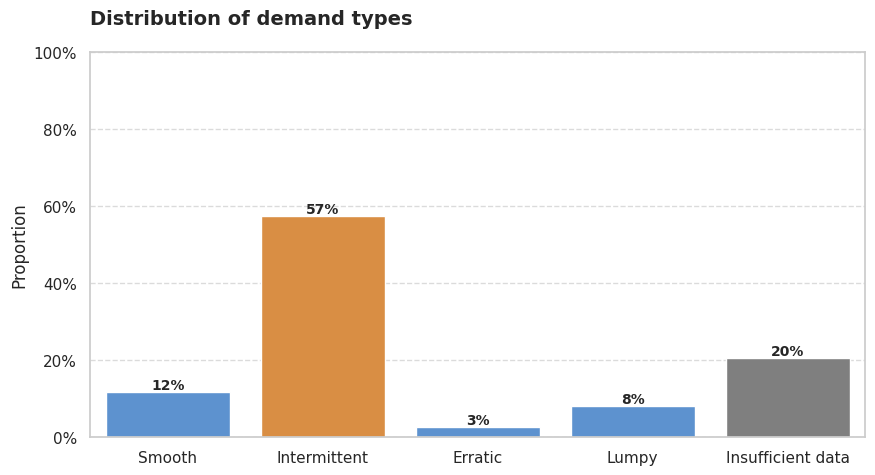

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10,5))

ax = sns.barplot(   # <- aquí guardamos el eje
    data=demand_summary_gb,
    x='demand_type',
    y='count_pct',
    palette=palette,
    hue='demand_type',
    legend=False
)

# Eje Y como porcentaje
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))
plt.ylim(0, 1)

# Título y etiquetas
plt.title("Distribution of demand types", fontsize=14, weight="bold", loc='left', pad=20)
plt.xlabel("")
plt.ylabel("Proportion")

# Porcentajes arriba de las barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height*100:.0f}%',   # sin decimales
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=10, weight='bold')

# Grid de fondo
plt.grid(axis='y', alpha=0.7, linestyle='--')

plt.show()

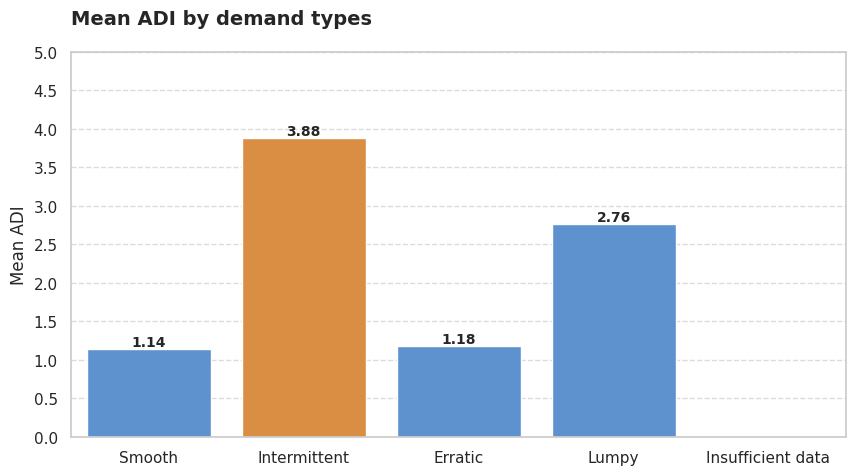

In [586]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10,5))

ax = sns.barplot(   # <- aquí guardamos el eje
    data=demand_summary_gb.query('demand_type != "Insufficient data"'),
    x='demand_type',
    y='mean_adi',
    palette=palette,
    hue='demand_type',
    legend=False,
    dodge=False
)

# Título y etiquetas
plt.title("Mean ADI by demand types", fontsize=14, weight="bold", loc='left', pad=20)
plt.xlabel("")
plt.ylabel("Mean ADI")

plt.ylim(0, 5)
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(0.5))

# Porcentajes arriba de las barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',   # sin decimales
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=10, weight='bold')

# Grid de fondo
plt.grid(axis='y', alpha=0.7, linestyle='--')

plt.show()

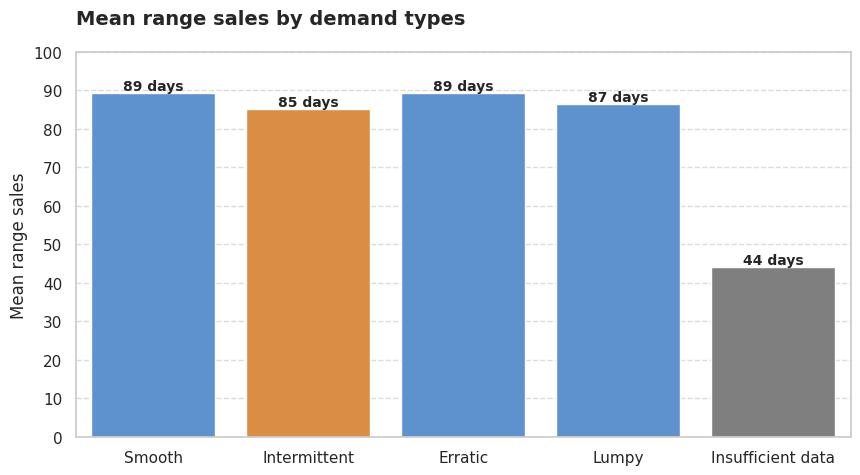

In [593]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10,5))

ax = sns.barplot(   # <- aquí guardamos el eje
    data=demand_summary_gb,
    x='demand_type',
    y='sales_range',
    palette=palette,
    hue='demand_type',
    legend=False,
    dodge=False
)

# Título y etiquetas
plt.title("Mean range sales by demand types", fontsize=14, weight="bold", loc='left', pad=20)
plt.xlabel("")
plt.ylabel("Mean range sales")

plt.ylim(0, 100)
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(10))

# Porcentajes arriba de las barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f} days',   # sin decimales
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=10, weight='bold')

# Grid de fondo
plt.grid(axis='y', alpha=0.7, linestyle='--')

plt.show()

## b) Examples

In [529]:
intermittent_item = 'HOBBIES_1_366_CA_1_validation'
smooth_item = 'HOBBIES_1_275_TX_2_validation'
erratic_item = 'HOUSEHOLD_1_177_WI_3_validation'
lumpy_item = 'FOODS_1_143_CA_1_validation'

items = [intermittent_item, smooth_item, erratic_item, lumpy_item]

display(demand_summary.query(f"id in {items}"))

,id,first_sale,last_sale,sales_range,total_days,days_with_sales,avg_sales,std_sales,ADI,CV2,demand_type
102,HOBBIES_1_366_CA_1_validation,2015-04-06,2015-06-30,85,91,23,1.217,0.412,3.957,0.115,Intermittent
1749,HOUSEHOLD_1_177_WI_3_validation,2015-04-01,2015-06-30,90,91,85,2.8,2.096,1.071,0.561,Erratic
8271,HOBBIES_1_275_TX_2_validation,2015-04-01,2015-06-30,90,91,87,2.977,1.398,1.046,0.22,Smooth
10785,FOODS_1_143_CA_1_validation,2015-04-03,2015-06-26,84,91,35,2.086,1.746,2.6,0.701,Lumpy


In [530]:
query = f"""
SELECT
    *
FROM read_parquet('{SALES_DATA_PATH}')
LEFT JOIN sales_data USING(id)
WHERE id IN {tuple(items)}
AND year = 2015 and quarter = 2
ORDER BY id, date
"""

sample_sales = ddb.query(query).to_df()

sample_sales = sample_sales[['demand_type','date', 'sales']]

In [531]:
import plotly.express as px

fig = px.line(
    sample_sales,
    x="date",
    y="sales",
    color="demand_type",
    category_orders={"demand_type": choices},
    markers=False,
    title="Sales over time by demand type",
    labels={
        "date": "Date",
        "sales": "Sales",
        "demand_type": "Demand type sample"
    },
    template="plotly_white",
    color_discrete_sequence=px.colors.qualitative.Set1,
    width=1600, height=500
)

fig.update_traces(line=dict(
    width=2)
    )

fig.update_layout(
    title=dict(
        x=0.5,
        font=dict(size=22,
                family="Arial",
                color="black")
    ),
    xaxis=dict(
        showgrid=False,
        gridcolor="lightgray",
        tickangle=0,
        gridwidth=1,
        griddash='dot'
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor="lightgray",
        gridwidth=1,
        griddash='dot',
        tick0=0,
        dtick=2,
        range=[0, 13]
    ),
    legend=dict(
        title="Demand type sample",
        orientation="v",
        xanchor="center",
        x=1.1,
        y=1,
    )
)

fig.show()


# Forecasting

In [532]:
def naive_model(series: pd.Series) -> pd.Series:
    """
    Forecast Naive: simplemente usa el valor anterior.
    Devuelve NaN en la primera posición.
    """
    return series.shift(1).round(0).astype('Int16')


def ses_model(series: pd.Series, alpha: float = 0.5) -> pd.Series:
    """
    Simple Exponential Smoothing con NumPy.
    alpha: factor de suavizamiento (0<alpha<=1).
    """
    values = series.to_numpy(dtype=float)
    result = np.empty_like(values, dtype=float)
    
    result[0] = values[0]

    for t in range(1, len(values)):
        result[t] = alpha * values[t] + (1 - alpha) * result[t-1]
    
    return pd.Series(result, index=series.index).round(0).astype('Int16')

sample_sales["naive_forecast"] = (
    sample_sales.groupby("demand_type", observed=True)["sales"]
    .transform(naive_model)
)

sample_sales["ses_forecast"] = (
    sample_sales.groupby("demand_type", observed=True)["sales"]
    .transform(lambda x: ses_model(x, alpha=0.5))
)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [533]:
smooth_sales = sample_sales[sample_sales['demand_type'] == 'Smooth'].copy()

fig = px.line(
    smooth_sales,
    x="date",
    y=["sales", "naive_forecast", "ses_forecast"],  # varias series
    labels={
        "value": "Unidades",
        "date": "Fecha",
        "variable": "Serie"
    },
    title="Ventas y Pronósticos (Naive vs SES) - Smooth",
    template="plotly_white",
    width=1200, height=500
)

fig.update_traces(line=dict(width=2))
fig.show()

In [534]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mdae(y_true, y_pred):
    return np.median(np.abs(y_true - y_pred))  

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true - np.mean(y_true)))

def bias(y_true, y_pred):
    return np.sum(y_pred - y_true) / np.sum(y_true)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # evita dividir por cero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))

def mase(y_true, y_naive, y_pred):
    n = len(y_true)
    num = np.sum(np.abs(y_true - y_pred)) / n
    den = np.sum(np.abs(y_true - y_naive)) / n
    return np.round(num / den, 3)

In [535]:
metrics_list = []

for item in choices:
    item_sales = sample_sales[sample_sales['demand_type'] == item]

    total_sales = item_sales['sales'].sum()
    total_naive_forecast = item_sales['naive_forecast'].sum()
    total_ses_forecast = item_sales['ses_forecast'].sum()
    
    metrics_list.append({
        "demand_type": item,
        "total_sales": total_sales,
        "total_naive_forecast": total_naive_forecast,
        "total_ses_forecast": total_ses_forecast,
        "rmse_naive": rmse(item_sales['sales'], item_sales['naive_forecast']),
        "rmse_ses": rmse(item_sales['sales'], item_sales['ses_forecast']),
        "wape_naive": wape(item_sales['sales'], item_sales['naive_forecast']),
        "wape_ses": wape(item_sales['sales'], item_sales['ses_forecast']),
        "bias_naive": bias(item_sales['sales'], item_sales['naive_forecast']),
        "bias_ses": bias(item_sales['sales'], item_sales['ses_forecast']),
        "mase_ses": mase(item_sales['sales'], item_sales['naive_forecast'], item_sales['ses_forecast'])
    })

summary_metrics = pd.DataFrame(metrics_list).round(3)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [536]:
summary_metrics

,demand_type,total_sales,total_naive_forecast,total_ses_forecast,rmse_naive,rmse_ses,wape_naive,wape_ses,bias_naive,bias_ses,mase_ses
0,Smooth,259,256,258,1.975,0.955,1.350,0.624,-0.004,-0.004,0.462
1,Intermittent,28,26,26,0.803,0.296,1.051,0.191,-0.071,-0.071,0.182
2,Erratic,238,236,241,2.996,1.271,1.289,0.517,0.008,0.013,0.401
3,Lumpy,73,73,72,2.060,0.908,1.224,0.479,0.000,-0.014,0.391
